## Part 1 - Stationary bandit problem

In [1]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# No of arms, no of steps, and no of simulations
arms = 10
steps = 2000
simulations = 1000

## 1.Greedy with non-optimistic initial values, i.e. 0.

In [3]:
def greedy_algorithm(arms, steps, simulations):
    # Initialize arrays
    avg_rewards = np.zeros(steps) # Store average reward at each step
    opt_action_per = np.zeros(steps) # Store percentage of optimal actions at each step

    for i in range(simulations):
        np.random.seed(i)  # Ensure reproducibility
        true_mean = np.random.normal(0, 1, arms)  # True mean of each arm, from N(0,1) distribution
        best_arm = np.argmax(true_mean)  # Identify the maximum mean arm, (optimal arm)

        Q = np.zeros(arms) # Estimated value for each arm (starts at 0 - non-optimistic)
        N = np.zeros(arms) # Count of times each arm is selected

        rewards = [] # Store reward received at each step
        counts = []   # Store count if the best arm was selected

        for j in range(steps):
            best_action = np.flatnonzero(Q == Q.max())  # Break ties uniformly
            action = np.random.choice(best_action)

            # Set count to 1 if the best arm was selected, else 0
            if action==best_arm:
              count=1 # Optimal action was selected
            else:
              count=0  # Suboptimal action was selected

            reward = np.random.normal(true_mean[action],1)  # Reward for the chosen action from a normal distribution, Reward ~ N(true_mean[action], 1)

            N[action]=N[action]+1     # Increment the count for the selected action
            Q[action]=Q[action]+(reward-Q[action])/(N[action])   # Update the estimated value (Q) of the selected action using incremental average

            counts.append(count) # Record if optimal action was chosen
            rewards.append(reward) # Record the reward received

        # Sum up rewards and optimal action across each simulation
        avg_rewards += rewards # Add the simulation's rewards to running total
        opt_action_per += counts # Add the simulation's optimal action counts to running

    # Average over all simulations
    avg_rewards /= simulations # Average reward at each step
    opt_action_per = 100*(opt_action_per / simulations)  # Convert to percentage

    return avg_rewards,opt_action_per

# Execute the algorithm with specified parameters
avg_rewards_dict, opt_action_dict=greedy_algorithm(10,2000,1000)



In [4]:
# Print final results
# Calculate average results across all simulations
print(f"Final average reward: {avg_rewards_dict[-1]:.3f}")
print(f"Final optimal action percentage: {opt_action_dict[-1]:.1f}%")

Final average reward: 1.024
Final optimal action percentage: 37.1%


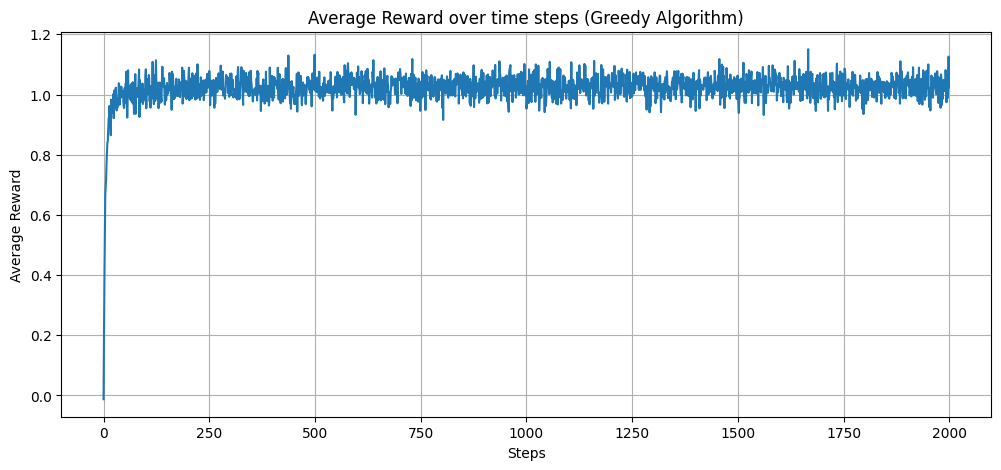

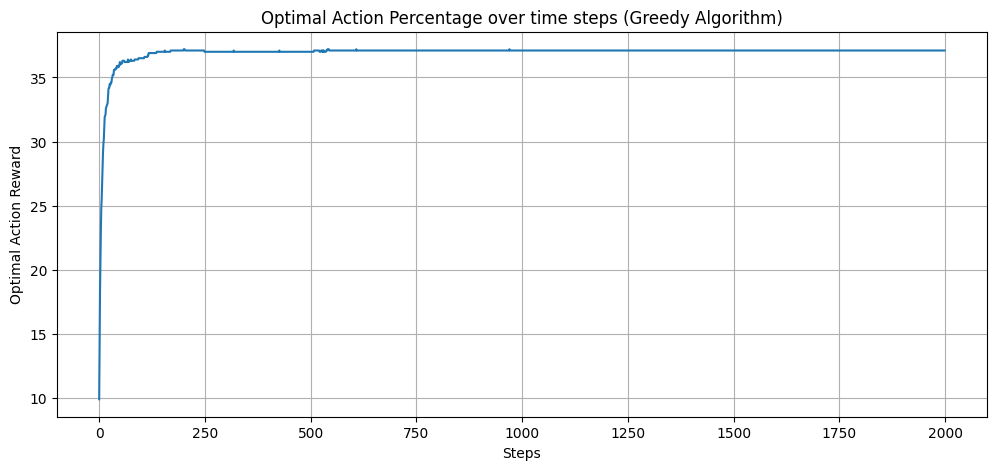

In [5]:
# Plotting the results
plt.figure(figsize=(12,5))
plt.plot(avg_rewards_dict)
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.title("Average Reward over time steps (Greedy Algorithm)")
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5))
plt.plot(opt_action_dict)
plt.xlabel("Steps")
plt.ylabel("Optimal Action Reward")
plt.title("Optimal Action Percentage over time steps (Greedy Algorithm)")
plt.grid(True)
plt.show()

## 2. Epsilon-greedy Algorithm

### 2.1 Pilot runs to choose epsilon values

In [6]:
def pilot_runs_epsilon_selection(p_arms=10, p_steps=2000, pilot_simulations=500):

 print(f"Pilot parameters: {p_arms} arms, {p_steps} steps, {pilot_simulations} simulations\n")

 # Experimenting small-scale values to choose optimal epsilon values
 testing_epsilon_values = [0.001, 0.005, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
 pilot_results = {}  # Store performance metrics for each epsilon
 pilot_curves = {}   # Store reward evolution curves for each epsilon

 for eps in testing_epsilon_values:
        print(f"Testing ε = {eps}...")

        # Run pilot experiment with fewer simulations
        avg_rewards = np.zeros(p_steps)
        total_optimal_actions = 0
        total_final_reward = 0

        # Run multiple simulations for this epsilon value
        for sim in range(pilot_simulations):
            np.random.seed(sim)  # Unique seeds for reproducibility

            # Set up bandit problem for this simulation
            true_mean = np.random.normal(0, 1, p_arms)  # True reward means for each arm
            best_arm = np.argmax(true_mean)           # Which arm is actually the best

            # Initialize learning algorithm
            Q = np.zeros(p_arms)  # Estimated values for each arm
            N = np.zeros(p_arms)  # Number of times each arm was selected
            sim_rewards = []    # Rewards received in this simulation
            sim_optimal = 0     # Count of optimal actions in this simulation

            # Run the epsilon-greedy algorithm for this simulation
            for step in range(p_steps):
                # EPSILON-GREEDY ACTION SELECTION
                if np.random.rand() < eps:
                    action = np.random.randint(p_arms)  # EXPLORE: random action
                else:
                    action = np.argmax(Q)             # EXPLOIT: best known action

                # Get reward and check if action was optimal
                reward = np.random.normal(true_mean[action], 1)
                if action == best_arm:
                    sim_optimal += 1

                # UPDATE Q-VALUES and N using incremental average
                N[action] += 1
                Q[action] += (reward - Q[action]) / N[action]

                sim_rewards.append(reward)

            # Accumulate results across all simulations for this epsilon
            avg_rewards += sim_rewards
            total_optimal_actions += sim_optimal
            total_final_reward += sim_rewards[-1]  # Last reward of this simulation

        # Calculate average performance metrics for this epsilon
        avg_rewards /= pilot_simulations  # Average reward at each step
        avg_optimal_pct = 100 * total_optimal_actions / (pilot_simulations * steps)
        avg_final_reward = total_final_reward / pilot_simulations
        print(avg_optimal_pct)
        # Store results for this epsilon value
        pilot_results[eps] = {
            'avg_final_reward': avg_final_reward,     # How good is final performance
            'avg_optimal_pct': avg_optimal_pct,       # How often did it pick best arm
            'overall_avg_reward': np.mean(avg_rewards) # Average across all steps
        }

        print(f"  Final reward: {avg_final_reward:.3f}, Optimal actions: {avg_optimal_pct:.1f}%")

 return pilot_results, testing_epsilon_values

In [7]:
# Running the pilot experiments
pilot_results, testing_epsilon_values = pilot_runs_epsilon_selection()

Pilot parameters: 10 arms, 2000 steps, 500 simulations

Testing ε = 0.001...
36.5574
  Final reward: 1.056, Optimal actions: 36.6%
Testing ε = 0.005...
47.2537
  Final reward: 1.289, Optimal actions: 47.3%
Testing ε = 0.05...
75.6769
  Final reward: 1.418, Optimal actions: 75.7%
Testing ε = 0.1...
75.5529
  Final reward: 1.397, Optimal actions: 75.6%
Testing ε = 0.2...
71.4103
  Final reward: 1.367, Optimal actions: 71.4%
Testing ε = 0.3...
65.1438
  Final reward: 1.126, Optimal actions: 65.1%
Testing ε = 0.4...
57.8136
  Final reward: 1.022, Optimal actions: 57.8%
Testing ε = 0.5...
50.7111
  Final reward: 0.776, Optimal actions: 50.7%
Testing ε = 0.6...
42.6131
  Final reward: 0.595, Optimal actions: 42.6%
Testing ε = 0.7...
34.5907
  Final reward: 0.422, Optimal actions: 34.6%
Testing ε = 0.8...
26.4417
  Final reward: 0.327, Optimal actions: 26.4%


In [8]:
# Extract data for plotting
eps_values = testing_epsilon_values
final_rewards = [pilot_results[eps]['avg_final_reward'] for eps in eps_values]
optimal_pcts = [pilot_results[eps]['avg_optimal_pct'] for eps in eps_values]

Text(0.07, 1.4177056013763016, 'Best: ε=0.05 \n 1.418')

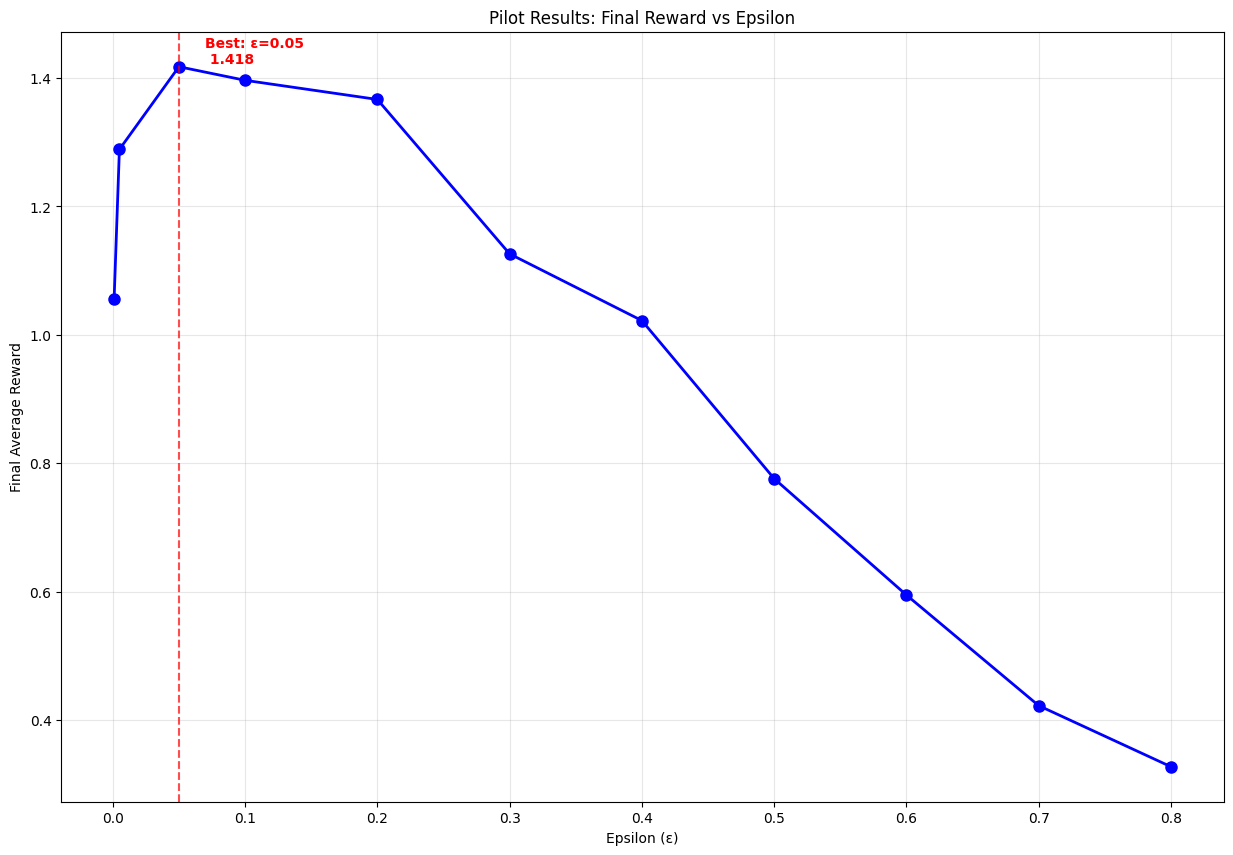

In [9]:
# Create plots to analyze pilot results
plt.figure(figsize=(15, 10))

# Final Reward vs Epsilon
plt.plot(eps_values, final_rewards, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Epsilon (ε)')
plt.ylabel('Final Average Reward')
plt.title('Pilot Results: Final Reward vs Epsilon')
plt.grid(True, alpha=0.3)

# Highlight the best performer
best_eps_reward = max(eps_values, key=lambda x: pilot_results[x]['avg_final_reward'])
plt.axvline(x=best_eps_reward, color='red', linestyle='--', alpha=0.7)
plt.text(best_eps_reward + 0.02, pilot_results[best_eps_reward]['avg_final_reward'],
         f'Best: ε={best_eps_reward} \n {pilot_results[best_eps_reward]["avg_final_reward"]:.3f}',
         ha='left', va='bottom', color='red', fontweight='bold')

Text(0.07, 75.6769, 'Best: ε=0.05\n75.7%')

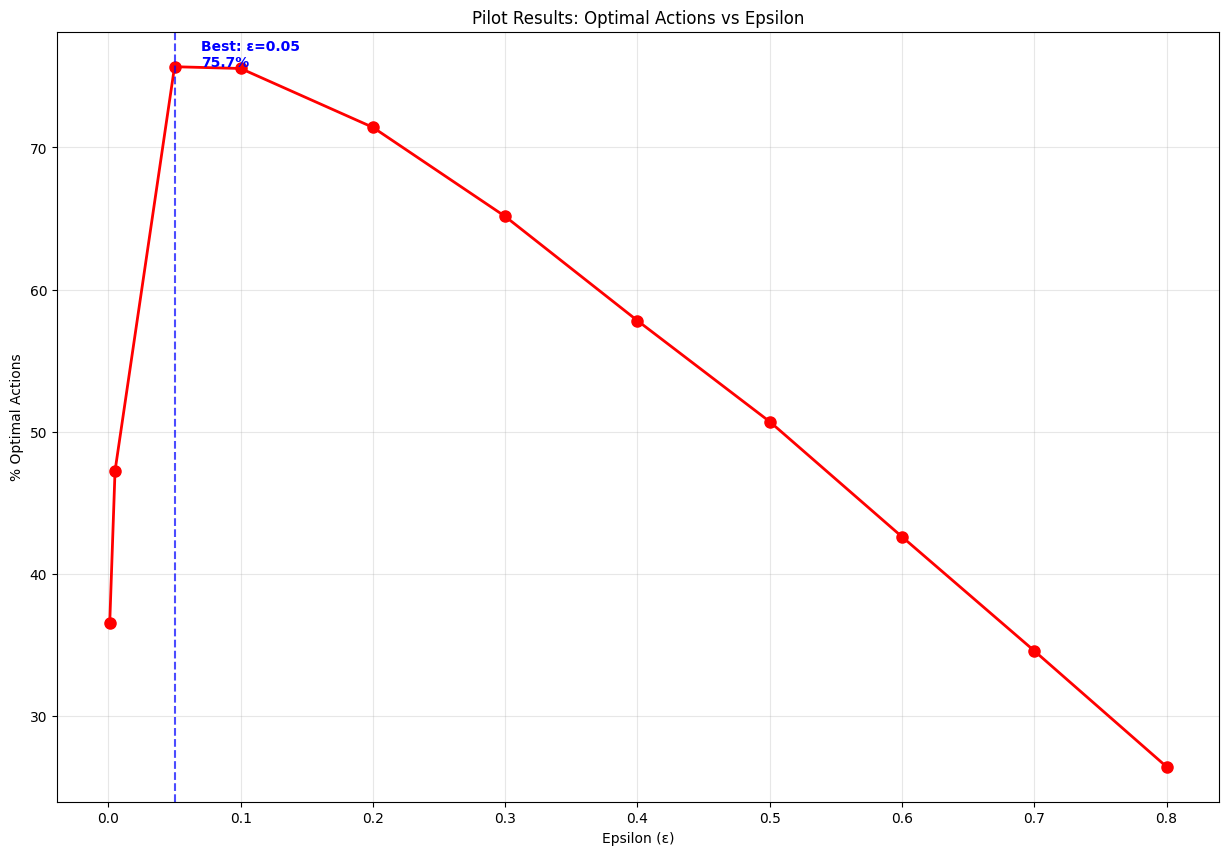

In [10]:
# Optimal Actions vs Epsilon
plt.figure(figsize=(15, 10))
plt.plot(eps_values, optimal_pcts, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Epsilon (ε)')
plt.ylabel('% Optimal Actions')
plt.title('Pilot Results: Optimal Actions vs Epsilon')
plt.grid(True, alpha=0.3)

# Highlight the best performer for optimal actions
best_eps_optimal = max(eps_values, key=lambda x: pilot_results[x]['avg_optimal_pct'])
plt.axvline(x=best_eps_optimal, color='blue', linestyle='--', alpha=0.7)
plt.text(best_eps_optimal + 0.02, pilot_results[best_eps_optimal]['avg_optimal_pct'],
         f'Best: ε={best_eps_optimal}\n{pilot_results[best_eps_optimal]["avg_optimal_pct"]:.1f}%',
         ha='left', va='baseline', color='blue', fontweight='bold')

In [11]:
# Sort epsilon values by their final reward performance
sorted_eps = sorted(testing_epsilon_values, key=lambda x: pilot_results[x]['avg_final_reward'], reverse=True)
print(sorted_eps)

[0.05, 0.1, 0.2, 0.005, 0.3, 0.001, 0.4, 0.5, 0.6, 0.7, 0.8]


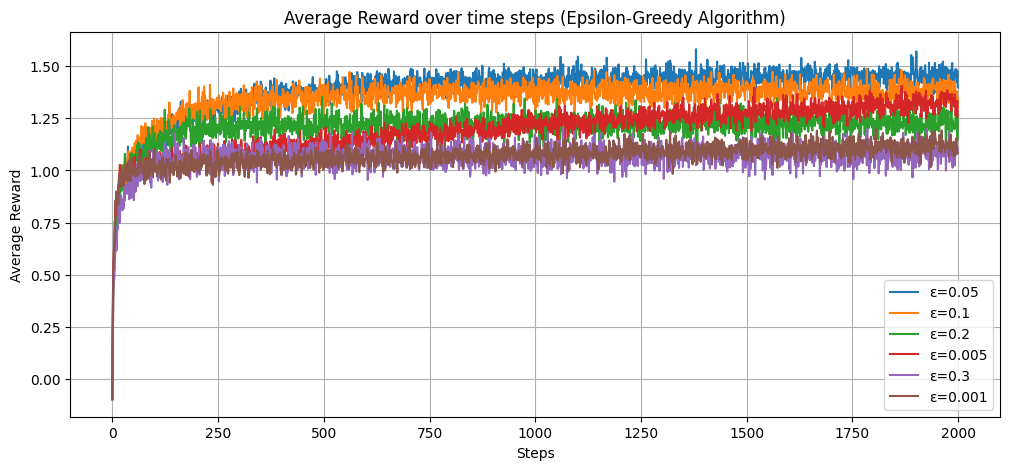

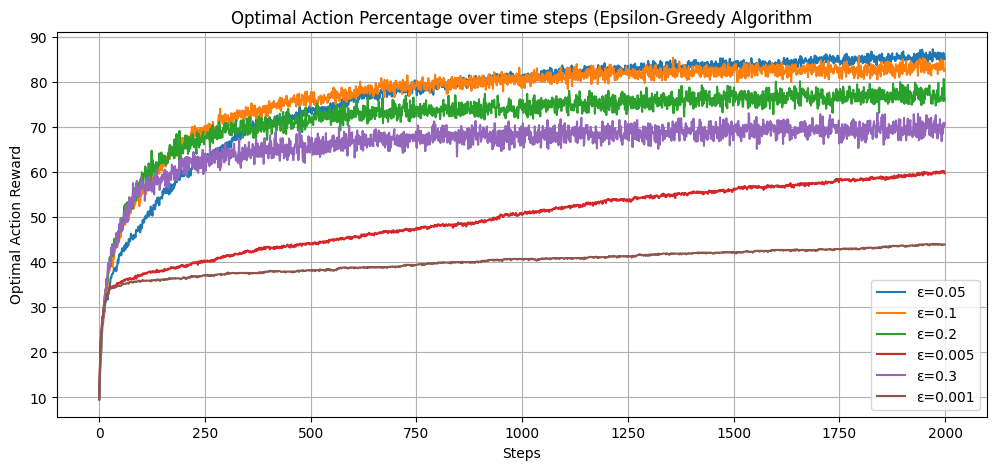

In [12]:
# Consider the best six five epsilon values
epsilon=[0.05, 0.1, 0.2, 0.005, 0.3, 0.001]

def epsilon_greedy_algorithm(arms, steps, simulations, epsilon):
    # Create empty dictionaries to store average rewards and optimal action percentages
    all_avg_reward = {}
    all_opt_action_per = {}

    for eps in epsilon:
        avg_rewards = np.zeros(steps)
        opt_action_per = np.zeros(steps)

         # Run the simulation 'simulations' number of times
        for j in range(simulations):
            np.random.seed(j)   # Set seed for reproducibility
            true_mean = np.random.normal(0, 1, arms)  # True mean of each arm
            best_arm = np.argmax(true_mean)  # Identify the maximum mean arm

            Q = np.zeros(arms)    # Estimated action values
            N = np.zeros(arms)    # Count of times each arm is chosen
            rewards = []
            counts = []

            # Loop through each time step
            for k in range(steps):
                x = np.random.rand()

                # ε-greedy action selection
                if x < eps:
                    action = np.random.randint(arms)  # Explore: select a random action
                else:
                    best_action = np.flatnonzero(Q == Q.max())  # Get all arms with max Q-value
                    action = np.random.choice(best_action)      # Randomly break ties

                reward=np.random.normal(true_mean[action],1)    # Reward for the chosen action from a normal distribution

                # Set count to 1 if the best arm was selected, else 0
                if action==best_arm:
                  count=1
                else:
                  count=0

                N[action]=N[action]+1     # Increment the count for the selected action
                Q[action]=Q[action]+(reward-Q[action])/(N[action])      # Update the estimated value (Q) of the selected action using incremental average

                rewards.append(reward)
                counts.append(count)

            #sum up rewards and optimal action across each simulation
            avg_rewards += rewards
            opt_action_per += counts

        # Average over all simulations
        avg_rewards /= simulations
        opt_action_per = 100 * (opt_action_per / simulations)

        # Store the average rewards and optimal action percentages for the each epsilon value
        all_avg_reward[eps] = avg_rewards
        all_opt_action_per[eps] = opt_action_per

    return all_avg_reward, all_opt_action_per

avg_rewards_dict, opt_action_dict = epsilon_greedy_algorithm(arms, steps, simulations, epsilon)

#ploting the average reward and optimatimal action percentage over time steps
plt.figure(figsize=(12,5))
for eps_val, rewards in avg_rewards_dict.items():
    plt.plot(rewards, label=f"ε={eps_val}")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.title("Average Reward over time steps (Epsilon-Greedy Algorithm)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5))
for eps_val, counts in opt_action_dict.items():
    plt.plot(counts, label=f"ε={eps_val}")
plt.xlabel("Steps")
plt.ylabel("Optimal Action Reward")
plt.title("Optimal Action Percentage over time steps (Epsilon-Greedy Algorithm")
plt.legend()
plt.grid(True)
plt.show()

## 3. Optimistic Greedy Algorithm

### 3.1 Optimistic differnt starting values with a greedy approach.

In [13]:
from scipy.stats import norm

def optimistic_greedy_algorithm(arms, steps, simulations, custom_q_values=None):

    # Check if we need to compare multiple Q values
    if isinstance(custom_q_values, list):
        return compare_multiple_q_values(arms, steps, simulations, custom_q_values)
    else:
        # Otherwise, run a single experiment
        return single_run(arms, steps, simulations, custom_q_values)

# Function to run the algorithm once using either custom or percentile-based optimistic value
def single_run(arms, steps, simulations, custom_q=None):
    # Single run with either calculated or custom Q value
    avg_rewards = np.zeros(steps)
    opt_action_per = np.zeros(steps)

    for i in range(simulations):
        np.random.seed(i)       # Ensure reproducibility
        true_mean = np.random.normal(0, 1, arms) # Generate random true means
        best_arm = np.argmax(true_mean)  # Identify the optimal arm

        # If no custom Q value is provided, calculating the a 99.5th percentile based on the best true mean
        if custom_q is None:
            # Calculate 99.5th percentile
            highest_mu = np.max(true_mean) # Find the highest μ (true mean)
            optimistic_value = norm.ppf(0.995, loc=highest_mu, scale=1)
            # print(f"Simulation {i}: Highest μ = {highest_mu:.3f}, "
            #       f"Calculated Q = {optimistic_value:.3f}")
        else:
            # Use custom Q value
            optimistic_value = custom_q
            highest_mu = np.max(true_mean)  # Find the highest μ (true mean)
            # print(f"Simulation {i}: Highest μ = {highest_mu:.3f}, "
            #       f"Custom Q = {custom_q}")

        # Initialize all Q-values with the optimistic estimate
        Q = np.full(arms, optimistic_value)

        # Print for first few simulations to see the variation
        if i < 5:
            if custom_q is None:
                print(f"Simulation {i}: Highest μ = {highest_mu:.3f}, "
                      f"Calculated Q = {optimistic_value:.3f}")
            else:
                print(f"Simulation {i}: Highest μ = {highest_mu:.3f}, "
                      f"Custom Q = {optimistic_value}")

        N = np.zeros(arms)

        # Greedy action selection
        for j in range(steps):
            best_actions = np.flatnonzero(Q == Q.max())     # Break ties randomly
            action = np.random.choice(best_actions)

            reward = np.random.normal(true_mean[action], 1)
            count = 1 if action == best_arm else 0       # Check if optimal arm

            N[action] += 1
            Q[action] += (reward - Q[action]) / N[action]   # Update Q-value by incremental average

            avg_rewards[j] += reward
            opt_action_per[j] += count

    # Average over all simulations
    avg_rewards /= simulations
    opt_action_per = 100 * (opt_action_per / simulations)

    return avg_rewards, opt_action_per

# Function to test and compare multiple Q-values
def compare_multiple_q_values(arms, steps, simulations, q_values):
    all_avg_rewards = {}
    all_opt_action_per = {}

    for q_val in q_values:
        print(f"\n--- Testing Q = {q_val} ---")
        avg_rewards, opt_action_per = single_run(arms, steps, simulations, q_val)
        all_avg_rewards[q_val] = avg_rewards
        all_opt_action_per[q_val] = opt_action_per

    return all_avg_rewards, all_opt_action_per

avg_rewards, opt_action_percentage = optimistic_greedy_algorithm(arms, steps, simulations)

Simulation 0: Highest μ = 2.241, Calculated Q = 4.817
Simulation 1: Highest μ = 1.745, Calculated Q = 4.321
Simulation 2: Highest μ = 1.640, Calculated Q = 4.216
Simulation 3: Highest μ = 1.789, Calculated Q = 4.364
Simulation 4: Highest μ = 0.694, Calculated Q = 3.269



--- Testing Q = 2.0 ---
Simulation 0: Highest μ = 2.241, Custom Q = 2.0
Simulation 1: Highest μ = 1.745, Custom Q = 2.0
Simulation 2: Highest μ = 1.640, Custom Q = 2.0
Simulation 3: Highest μ = 1.789, Custom Q = 2.0
Simulation 4: Highest μ = 0.694, Custom Q = 2.0

--- Testing Q = 2.5 ---
Simulation 0: Highest μ = 2.241, Custom Q = 2.5
Simulation 1: Highest μ = 1.745, Custom Q = 2.5
Simulation 2: Highest μ = 1.640, Custom Q = 2.5
Simulation 3: Highest μ = 1.789, Custom Q = 2.5
Simulation 4: Highest μ = 0.694, Custom Q = 2.5

--- Testing Q = 2.75 ---
Simulation 0: Highest μ = 2.241, Custom Q = 2.75
Simulation 1: Highest μ = 1.745, Custom Q = 2.75
Simulation 2: Highest μ = 1.640, Custom Q = 2.75
Simulation 3: Highest μ = 1.789, Custom Q = 2.75
Simulation 4: Highest μ = 0.694, Custom Q = 2.75

--- Testing Q = 3.0 ---
Simulation 0: Highest μ = 2.241, Custom Q = 3.0
Simulation 1: Highest μ = 1.745, Custom Q = 3.0
Simulation 2: Highest μ = 1.640, Custom Q = 3.0
Simulation 3: Highest μ = 1.78

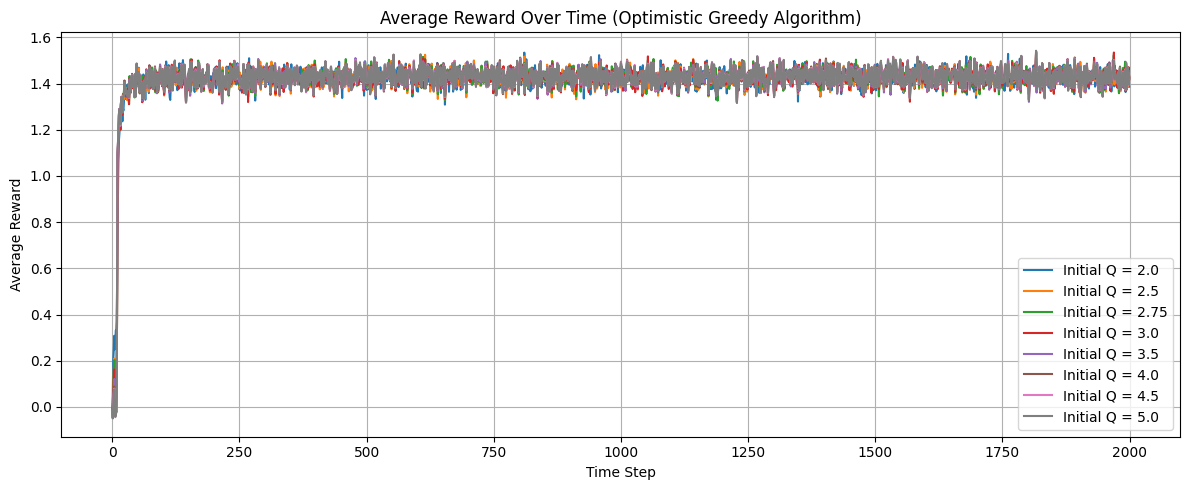

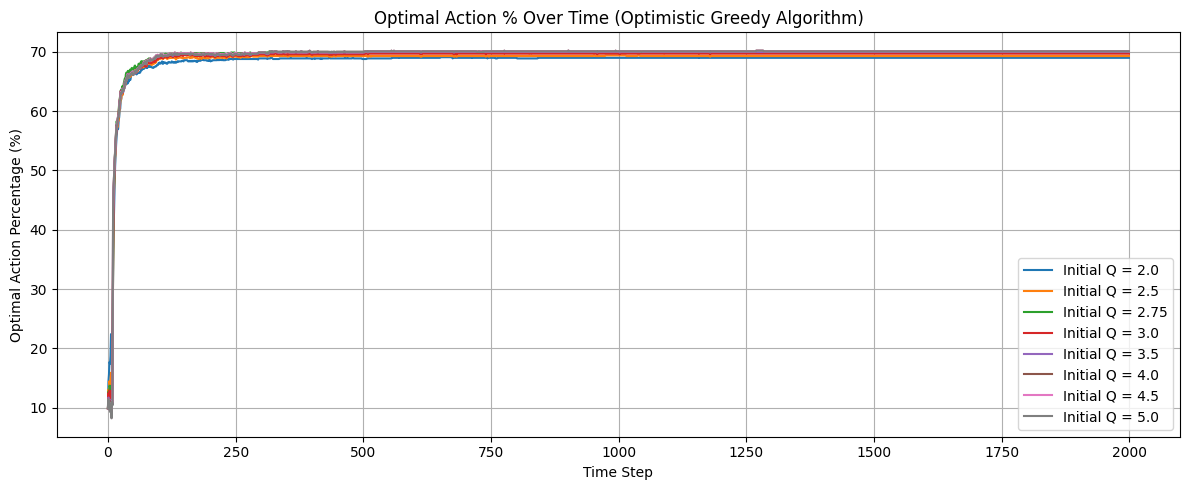

In [14]:
q_values_to_test = [2.0, 2.5, 2.75, 3.0, 3.5, 4.0, 4.5, 5.0]

# Run with multiple Q values
avg_rewards_dict, opt_action_dict = optimistic_greedy_algorithm(arms, steps, simulations, q_values_to_test)

plt.figure(figsize=(12, 5))
for val, rewards in avg_rewards_dict.items():
    plt.plot(rewards, label=f'Initial Q = {val}')
plt.title("Average Reward Over Time (Optimistic Greedy Algorithm)")
plt.xlabel("Time Step")
plt.ylabel("Average Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting Optimal Action Percentage
plt.figure(figsize=(12, 5))
for val, opt_percent in opt_action_dict.items():
    plt.plot(opt_percent, label=f'Initial Q = {val}')
plt.title("Optimal Action % Over Time (Optimistic Greedy Algorithm)")
plt.xlabel("Time Step")
plt.ylabel("Optimal Action Percentage (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# Function to evaluate and find the best Q value based on final rewards
def find_best_q_value(avg_rewards_dict, opt_action_dict):
    best_q = None      # Store the best Q value
    best_final_reward = -float('inf')     # Start with a very low reward to compare

    # Print header for performance summary
    print("\n" + "="*50)
    print("Q VALUE Performance Analysis")
    print("="*50)
    print(f"{'Q Value':<8} {'Final Reward':<12} {'Optimal %':<10}")
    print("-" * 35)

    # Loop through each Q value tested
    for q_val in avg_rewards_dict.keys():
        final_reward = avg_rewards_dict[q_val][-1]
        final_opt_pct = opt_action_dict[q_val][-1]

        # Print performance of current Q
        print(f"{q_val:<8} {final_reward:<12.3f} {final_opt_pct:<10.1f}%")

        # Track the best-performing Q value
        if final_reward > best_final_reward:
            best_final_reward = final_reward
            best_q = q_val

    print(f"\nBest Q Value: {best_q} (Final Reward: {best_final_reward:.3f})")
    return best_q

# Run to find the best Q value
best_q = find_best_q_value(avg_rewards_dict, opt_action_dict)


Q VALUE Performance Analysis
Q Value  Final Reward Optimal % 
-----------------------------------
2.0      1.386        69.0      %
2.5      1.427        69.3      %
2.75     1.421        70.0      %
3.0      1.417        69.7      %
3.5      1.421        70.0      %
4.0      1.427        70.1      %
4.5      1.427        70.1      %
5.0      1.426        70.1      %

Best Q Value: 4.0 (Final Reward: 1.427)


In [16]:
# Run baseline (99.5th percentile) for comparison
print(f"\n=== RUNNING BASELINE (99.5th Percentile) ===")
baseline_rewards, baseline_opt_pct = optimistic_greedy_algorithm(arms, steps, simulations)


=== RUNNING BASELINE (99.5th Percentile) ===
Simulation 0: Highest μ = 2.241, Calculated Q = 4.817
Simulation 1: Highest μ = 1.745, Calculated Q = 4.321
Simulation 2: Highest μ = 1.640, Calculated Q = 4.216
Simulation 3: Highest μ = 1.789, Calculated Q = 4.364
Simulation 4: Highest μ = 0.694, Calculated Q = 3.269



=== BEST Q VALUE (4.0) vs BASELINE COMPARISON ===


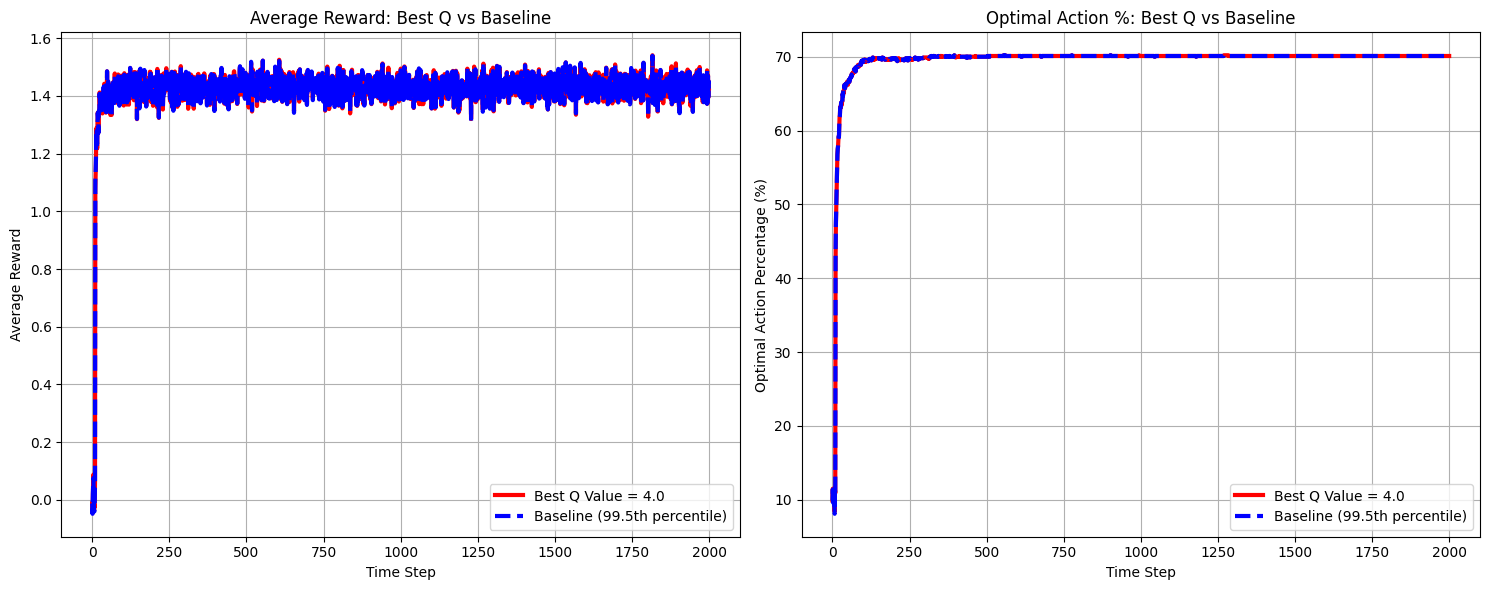

In [17]:
# Create separate graph showing ONLY the best Q value vs baseline
print(f"\n=== BEST Q VALUE ({best_q}) vs BASELINE COMPARISON ===")

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(avg_rewards_dict[best_q], label=f'Best Q Value = {best_q}',
         linewidth=3, color='red')
plt.plot(baseline_rewards, label='Baseline (99.5th percentile)',
         linewidth=3, color='blue', linestyle='--')
plt.title("Average Reward: Best Q vs Baseline")
plt.xlabel("Time Step")
plt.ylabel("Average Reward")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(opt_action_dict[best_q], label=f'Best Q Value = {best_q}',
         linewidth=3, color='red')
plt.plot(baseline_opt_pct, label='Baseline (99.5th percentile)',
         linewidth=3, color='blue', linestyle='--')
plt.title("Optimal Action %: Best Q vs Baseline")
plt.xlabel("Time Step")
plt.ylabel("Optimal Action Percentage (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 4. Gradient bandit algorithm

### 4.1 Gradient bandit algorithm with different learning rates α

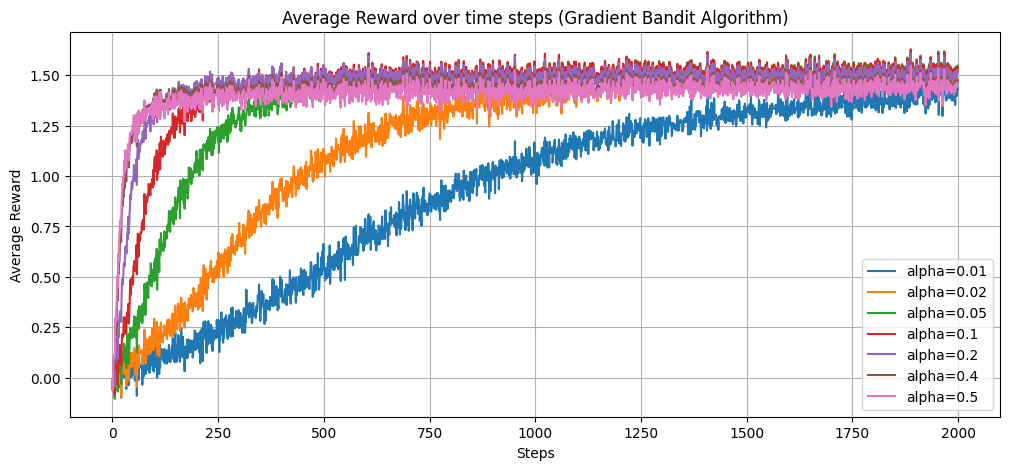

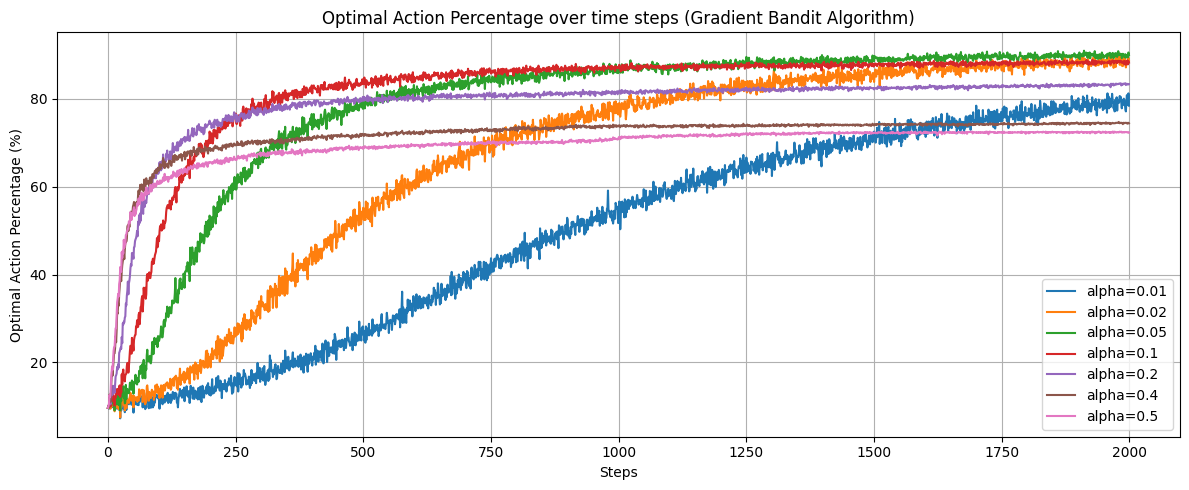

In [18]:
alpha_list = [0.01, 0.02, 0.05,0.1, 0.2, 0.4, 0.5]

def gradient_bandit(arms,steps,simulations, alpha_list):
    all_alpha_avg_rewards = {}
    all_alpha_opt_action_per = {}

    for alpha in alpha_list:
        avg_rewards = np.zeros(steps)
        opt_action_per = np.zeros(steps)

        for i in range(simulations):
            np.random.seed(i)   # Ensure reproducibility
            true_mean = np.random.normal(0, 1, arms)  # True mean of each arm
            best_arm = np.argmax(true_mean)  # Identify the maximum mean arm

            H = np.zeros(arms)
            baseline = 0

            rewards = []
            counts = []

            for j in range(steps):
                exp_H = np.exp(H - np.max(H))  # Numerical stability
                probs = exp_H / np.sum(exp_H)

                action = np.random.choice(arms, p=probs)    # Select an action based on the probability distribution 'probs'
                reward = np.random.normal(true_mean[action], 1)

                baseline= baseline+ (reward - baseline) / (j + 1)

                for a in range(arms):
                    if a == action:
                        H[a] =H[a]+ alpha * (reward - baseline) * (1 - probs[a])
                    else:
                        H[a] =H[a]- alpha * (reward - baseline) * probs[a]

                # Set count to 1 if the best arm was selected, else 0
                if action==best_arm:
                  count=1
                else:
                  count=0

                rewards.append(reward)
                counts.append(count)

            avg_rewards += rewards
            opt_action_per += counts

        # Average over all simulations
        avg_rewards =avg_rewards/simulations
        opt_action_per = 100 * (opt_action_per / simulations)

        # Store the average rewards and optimal action percentages for the each alpha value
        all_alpha_avg_rewards[alpha] = avg_rewards
        all_alpha_opt_action_per[alpha] = opt_action_per

    return all_alpha_avg_rewards, all_alpha_opt_action_per


# Run the function
avg_rewards_dict, opt_action_dict = gradient_bandit(arms,steps,simulations, alpha_list)

# Plot
plt.figure(figsize=(12, 5))
for alpha_val, rewards_data in avg_rewards_dict.items():
    plt.plot(np.arange(steps), rewards_data, label=f'alpha={alpha_val}')
plt.title("Average Reward over time steps (Gradient Bandit Algorithm)")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.grid(True)
plt.legend()

plt.figure(figsize=(12, 5))
for alpha_val, opt_data in opt_action_dict.items():
    plt.plot(np.arange(steps), opt_data, label=f'alpha={alpha_val}')
plt.title("Optimal Action Percentage over time steps (Gradient Bandit Algorithm)")
plt.xlabel("Steps")
plt.ylabel("Optimal Action Percentage (%)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [19]:
avg_rewards_dict, opt_action_dict = gradient_bandit(arms, steps, simulations, alpha_list)

# Calculate final performance metrics for each alpha
print("=" * 60)
print("ALPHA VALUE Performance Analysis")
print("=" * 60)

alpha_performance = []
for alpha in alpha_list:
    final_reward = avg_rewards_dict[alpha][-1]  # Last reward value
    final_optimal = opt_action_dict[alpha][-1]  # Last optimal percentage
    alpha_performance.append((alpha, final_reward, final_optimal))

# Print table header
print(f"{'Alpha Value':<12} {'Final Reward':<15} {'Optimal %':<12}")
print("-" * 40)

# Print each alpha's performance
for alpha, reward, optimal in alpha_performance:
    print(f"{alpha:<12} {reward:<15.3f} {optimal:<12.1f}%")

# Find and highlight the best alpha based on final reward
best_alpha = max(alpha_performance, key=lambda x: x[1])
print(f"\nBest Alpha Value: {best_alpha[0]} (Final Reward: {best_alpha[1]:.3f})")

ALPHA VALUE Performance Analysis
Alpha Value  Final Reward    Optimal %   
----------------------------------------
0.01         1.429           78.4        %
0.02         1.523           88.7        %
0.05         1.548           89.9        %
0.1          1.539           88.2        %
0.2          1.525           83.3        %
0.4          1.478           74.4        %
0.5          1.463           72.3        %

Best Alpha Value: 0.05 (Final Reward: 1.548)


## Comparing all the Algorithms

In [20]:
avg_rewards_dict_greedy, opt_action_dict_greedy=greedy_algorithm(10,2000,1000)
avg_rewards_dict_epsilon_greedy, opt_action_dict_epsilon_greedy = epsilon_greedy_algorithm(10, 2000, 1000, [0.05])
avg_rewards_dict_opt_geedy, opt_action_dict_opt_greedy=optimistic_greedy_algorithm(10, 2000, 1000, [4.0])
avg_rewards_dict_gradient, opt_action_dict_gradient = gradient_bandit(10,2000,1000, [0.05])


--- Testing Q = 4.0 ---
Simulation 0: Highest μ = 2.241, Custom Q = 4.0
Simulation 1: Highest μ = 1.745, Custom Q = 4.0
Simulation 2: Highest μ = 1.640, Custom Q = 4.0
Simulation 3: Highest μ = 1.789, Custom Q = 4.0
Simulation 4: Highest μ = 0.694, Custom Q = 4.0


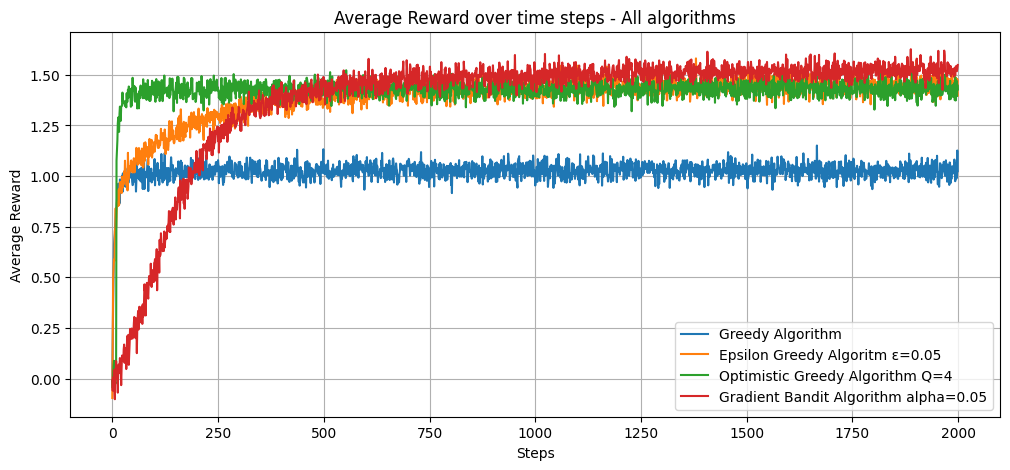

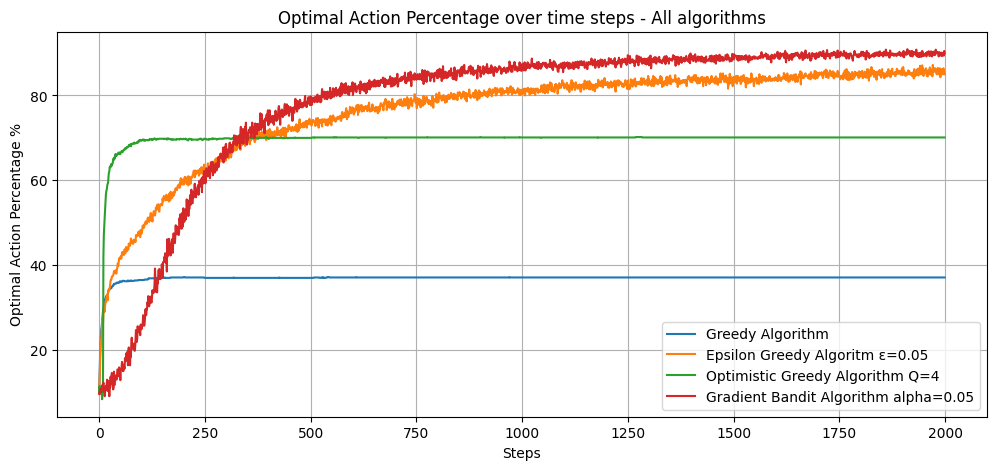

In [21]:
# Plotting the comparison results
plt.figure(figsize=(12, 5))
plt.plot(avg_rewards_dict_greedy,label="Greedy Algorithm")
for eps_val, rewards in avg_rewards_dict_epsilon_greedy.items():
    plt.plot(rewards, label="Epsilon Greedy Algoritm ε=0.05")
for val, rewards in avg_rewards_dict_opt_geedy.items():
    plt.plot(rewards, label="Optimistic Greedy Algorithm Q=4")
for alpha_val, rewards_data in avg_rewards_dict_gradient.items():
    plt.plot(np.arange(2000), rewards_data, label="Gradient Bandit Algorithm alpha=0.05")
plt.title("Average Reward over time steps - All algorithms")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.grid(True)
plt.legend()

plt.figure(figsize=(12,5))
plt.plot(opt_action_dict_greedy,label="Greedy Algorithm")
for eps_val, counts in opt_action_dict_epsilon_greedy.items():
    plt.plot(counts, label="Epsilon Greedy Algoritm ε=0.05")
for val, opt_percent in opt_action_dict_opt_greedy.items():
    plt.plot(opt_percent, label="Optimistic Greedy Algorithm Q=4")
for alpha_val, opt_data in  opt_action_dict_gradient.items():
    plt.plot(np.arange(2000), opt_data, label="Gradient Bandit Algorithm alpha=0.05")
plt.xlabel("Steps")
plt.ylabel("Optimal Action Percentage %")
plt.title("Optimal Action Percentage over time steps - All algorithms")
plt.grid(True)
plt.legend()
plt.show()